<a href="https://colab.research.google.com/github/armandossrecife/piloto/blob/main/classes_criticas_cassandra_teste_correlacao_todosissues_e_bugs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependências

In [1]:
print('Install dependencies...')
print('Update apt. ')
!sudo apt update > apt_update.log
print('Install software-properties-common.')
!sudo apt install software-properties-common > spc.log
print('Add ppa-git-core repository.')
!sudo add-apt-repository -y ppa:git-core/ppa > ppa_git_core.log
print('Install the latest version of git.')
!sudo apt install -y git > install_git.log
!git --version > git_version.log
print('Install pydriller')
!pip3 install pydriller > install_pydriller.log
!pip3 list | grep PyDriller > versao_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install dependencies...
Update apt. 


Install software-properties-common.


Add ppa-git-core repository.
Install the latest version of git.


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Install pydriller
Install gitpython.
Install Jira Python lib.
All depenpencies installed!
Details in install.log


# Apoio (Funções)

In [84]:
# 1. import libraries and modules
import pandas as pd
import pydriller
from jira import JIRA
import os
import subprocess
import requests
import threading
import datetime
import configparser # para manipular arquivos .conf
import tqdm
from datetime import datetime, timedelta
import re
import tqdm
import seaborn as sns

# 2. Define variables
github_repo_url = 'https://github.com/apache/cassandra.git'
SERVIDOR_JIRA = 'https://issues.apache.org/jira'

def create_file_credentials():
  file_name = 'credentials.conf'
  try:
    with open(file_name, mode='w') as f_credentials:
      f_credentials.write('[credentials]')
      f_credentials.write('\n')
      f_credentials.write('username = ?')
      f_credentials.write('\n')
      f_credentials.write('password = ?')
      print(f'The file {file_name}. You have to update username/password')
  except Exception as ex:
    print(f'Erro during creation of {file_name}: {str(ex)} ')

def connect_to_jira_server(url_server):
  file_name = 'credentials.conf'
  try:
    config = configparser.ConfigParser()
    config.read(file_name)
    username = config['credentials']['username']
    password = config['credentials']['password']

    # Create a JIRA client instance
    jira = JIRA(
        server=url_server,  # Replace with the Cassandra JIRA server URL
        basic_auth=(username, password),  # Replace with your JIRA credentials
    )
    print(f'Servidor {url_server} acessado com sucesso!')
  except Exception as ex:
    print(f'Erro ao acessar o Jira: {str(ex)}')
  return jira

#!cd cassandra && git rev-list --count HEAD
def get_total_commit_count(repository_path):
    command = ["git", "rev-list", "--count", "HEAD"]
    result = subprocess.run(command, cwd=repository_path, stdout=subprocess.PIPE, text=True)
    total_commit_count = int(result.stdout.strip())
    return total_commit_count

def generate_intervals_between_dates(date1, date2, distance=120):
  start_date = datetime(date1[0], date1[1], date1[2])
  end_date = datetime(date2[0], date2[1], date2[2])
  interval_days = distance
  # Initialize a list to store the intervals
  intervals = []
  # Initialize the current date as the start date
  current_date = start_date
  # Loop to generate intervals until the current date is less than or equal to the end date
  while current_date < end_date:
      interval = (current_date, current_date + timedelta(days=interval_days - 1))
      intervals.append(interval)
      current_date += timedelta(days=interval_days)
  return intervals

def convert_interval_dates(dates):
  list_interval_dates = []
  for each in dates:
    date1 = each[0]
    # Convert the date to a string in the format "YYYY/MM/DD".
    str_date1 = date1.strftime("%Y/%m/%d")
    date2 = each[1]
    str_date2 = date2.strftime("%Y/%m/%d")
    elemento = str_date1, str_date2
    list_interval_dates.append(elemento)
  return list_interval_dates

def gera_lista_sentencas(project_name, dates):
  lista_sentencas = []
  for each in dates:
    str_date1 = each[0].strftime("%Y/%m/%d")
    str_date2 = each[1].strftime("%Y/%m/%d")
    sentenca = f'project={project_name} and created>="{str_date1}" and created<="{str_date2}"'
    lista_sentencas.append(sentenca)
  return lista_sentencas

def lista_acesso_jira(lista_sentencas):
  print('Aguarde...')
  t1 = datetime.now()
  lista_issues_by_date = []
  for each in lista_sentencas:
    issues_by_date_temp = jira.search_issues(each,maxResults=1000)
    print(each, len(issues_by_date_temp))
    lista_issues_by_date.append(issues_by_date_temp)
  t2 = datetime.now()
  print(t2)
  print(f'Tempo da consulta: {t2-t1}')
  return lista_issues_by_date

def find_cassandra_pattern(input_string):
    # Define the pattern using regular expression
    pattern = r'(CASSANDRA-\d+)'

    # Use re.search() to find the pattern in the input_string
    match = re.search(pattern, input_string)

    # If a match is found, return the matched pattern; otherwise, return None
    if match:
        return match.group(1)
    else:
        return None

# extrai o issue tracker salvo na mensagem de cada commit
def extract_cassandra_issue(text_content, project_id='CASSANDRA-'):
  """
  Extract the CASSANDRA-XYZ issue from the text.

  Args:
    text: The text to extract the issue from.

  Returns:
    The issue number, or None if the issue cannot be found.
  """

  issues_number = []

  lines = text_content.split('\n')
  for line in lines:
    issue_number = find_cassandra_pattern(line)
    if issue_number:
      issues_number.append(issue_number)
  return issues_number

def get_modified_files_from_commit(key):
  list_files = []
  MESSAGE = 0
  MODIFIED_FILES = 1
  QTD_MODIFIED_FILES = 2
  for each in key:
    if each in dict_commit_modified_files.keys():
      if dict_commit_modified_files[each] is not None:
        list_files.append(dict_commit_modified_files[each][MODIFIED_FILES])
  return list_files

### Analisa os issues que foram salvos em commits ###

def get_list_issues_number(commits_file_path='/content/cassandra/all_commits_msg.txt'):
  print('Gera a lista de issue number que aparece nas mensagens dos commits.')
  with open(commits_file_path, mode='r') as f_commits_msg:
    conteudo = f_commits_msg.read()

  list_issue_number = extract_cassandra_issue(text_content=conteudo, project_id='CASSANDRA-')

  clean_list_issue_number = []
  for each in list_issue_number:
    item = each.split()[0]
    item = item.replace(")", "")
    if item != 'CASSANDRA-' and item != 'CASSANDRA-CASSANDRA':
      clean_list_issue_number.append(item)

  return clean_list_issue_number


def get_list_cassandra_issues_analyzed(clean_list_issue_number):
  print('Gera a lista de issues analisados que aparecem nas mensagens dos commits')
  total_items = len(clean_list_issue_number)
  i = 0
  iterable_list_issue_number = tqdm.tqdm(clean_list_issue_number, total=total_items)
  # Faz a limpeza para garantir o id do Issue tracker
  list_cassandra_issues_analyzed = []
  for each in iterable_list_issue_number:
    list_cassandra_issues_analyzed.append(each)
    percentage = (i + 1) / total_items * 100
    iterable_list_issue_number.set_description(f"Progress Message Analysis")
    i += 1

  return list_cassandra_issues_analyzed

### Cria um Dataframe referente aos issues coletados ###

def generate_dict_all_issues(concatenated_list):
  dict_all_issues = {}

  list_key, list_summary, list_status, list_description, list_priority, list_timeestimate, list_timespent, list_issuetype = list(), list(), list(), list(), list(), list(), list(), list()

  i = 1
  for issue in concatenated_list:
      list_key.append(issue.key)
      list_summary.append(issue.fields.summary)
      list_status.append(issue.fields.status)
      list_description.append(issue.fields.description)
      list_priority.append(issue.fields.priority)
      list_timespent.append(issue.fields.timespent)
      list_timeestimate.append(issue.fields.timeestimate)
      list_issuetype.append(issue.fields.issuetype)
      i += 1

  dict_all_issues['key'] = list_key
  dict_all_issues['issue_type'] = list_issuetype
  dict_all_issues['summary'] = list_summary
  dict_all_issues['status'] = list_status
  dict_all_issues['description'] = list_description
  dict_all_issues['priority'] = list_priority
  dict_all_issues['timespent'] = list_timespent
  dict_all_issues['timeestimate'] = list_timeestimate

  return dict_all_issues

### Gera os dicionários com commits e arquivos modificados ###
def extract_commits_info(total_commit_count):
  print('Extrai informações dos commits.')
  # 4. Extract Commit
  total_commits = total_commit_count
  dict_commit_modified_files = {}
  i = 0

  iterable_commits = tqdm.tqdm(pydriller.Repository("cassandra").traverse_commits(), total=total_commits)

  for commit in iterable_commits:
    list_modified_files = []
    for m in commit.modified_files:
      list_modified_files.append(m.filename)
    qtd_modified_files = len(list_modified_files)
    commit_message = commit.msg
    elemento = (commit_message, list_modified_files, qtd_modified_files)
    dict_commit_modified_files[commit.hash] = elemento
    percentage = (i + 1) / total_commits * 100
    iterable_commits.set_description(f"Progress Commit Analysis")
    i += 1

  return dict_commit_modified_files

def generate_dict_message_commits_valido(dict_commit_modified_files, list_cassandra_issues_analyzed):
  print('Gera o dicionário com issues em mensagens validas dos commits')
  dict_message_commits_valido = {}

  i = 0
  total_commits = len(dict_commit_modified_files)
  iterable_dict_commit_modified_files = tqdm.tqdm(dict_commit_modified_files.items(), total=total_commits)

  for k,v in iterable_dict_commit_modified_files:
    if v[0] is not None:
      for cassandra_issue in list_cassandra_issues_analyzed:
        if cassandra_issue != 'CASSANDRA-' and cassandra_issue in str(v[0]):
          dict_message_commits_valido[k] = cassandra_issue
          break
    percentage = (i + 1) / total_commits * 100
    iterable_dict_commit_modified_files.set_description(f"Progress Dict Message Commit Analysis")
    i += 1

  return dict_message_commits_valido

def generate_dict_key_commit_valido(lista_key_cassandra_all_issues, dict_message_commits_valido):
  print('Gera o dicionario de key commit valido')
  dict_key_commit_valido = {}
  list_commits_by_key = []

  i = 0
  j = 0
  total_issues = len(lista_key_cassandra_all_issues)
  iterable_lista_key_cassandra_all_issues = tqdm.tqdm(lista_key_cassandra_all_issues, total=total_issues)

  for each_issue in iterable_lista_key_cassandra_all_issues:
    list_commits_by_key = []
    for k,v in dict_message_commits_valido.items():
      if each_issue == v:
        i +=1
        list_commits_by_key.append(k)
    dict_key_commit_valido[each_issue] = list_commits_by_key
    percentage = (j + 1) / total_issues * 100
    iterable_lista_key_cassandra_all_issues.set_description(f"Progress Dict Key Commit Analysis")
    j += 1

  return dict_key_commit_valido

# Acessa o Servidor do Jira e cria uma instância de conexão

In [3]:
# Cria um arquivo de credencias para poder acessar o servidor do JIRA
# Você precisa criar o arquivo e informar o usuário/senha de acesso ao servidor JIRA
create_file_credentials()

The file credentials.conf. You have to update username/password


In [4]:
jira = connect_to_jira_server(url_server=SERVIDOR_JIRA)

Servidor https://issues.apache.org/jira acessado com sucesso!


# Extrai todos os commits do repositório (Cassandra)

In [5]:
!git clone https://github.com/apache/cassandra.git

Cloning into 'cassandra'...
remote: Enumerating objects: 399017, done.
remote: Counting objects: 100% (2079/2079), done.
remote: Compressing objects: 100% (897/897), done.
remote: Total 399017 (delta 962), reused 1798 (delta 858), pack-reused 396938
Receiving objects: 100% (399017/399017), 394.40 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (232951/232951), done.


In [6]:
# Mostra todos os commits
!cd cassandra && git log --pretty="%H;%ai;%s" > all_commits_full.txt
!cd cassandra && git log --pretty="%H %s" > all_commits_msg.txt
!echo "10 primeiros commits all_commits_msg.txt"
!cd cassandra && head all_commits_msg.txt
!echo "..."

# Total de commits registrados entre as versões cassandra-3.0.0...cassandra-3.11.11
!echo "Total de commits registrados "
!cd cassandra && cat all_commits_msg.txt | wc -l

10 primeiros commits all_commits_msg.txt
188df44c8cce77aebb05f2daa7a54001c98f50b9 Merge branch 'cassandra-5.0' into trunk
15f355a0062148e1ca511e8fc515e0cba380790d Remove wrong assertion in SSTableLoader
89065ffa2189861c0437fd1f1a5748df006e8907 Merge branch 'cassandra-5.0' into trunk
2b23fc58aa86a1cd0c98f97ddcf43305869d041e Fix accessing java.nio.Bits.TOTAL_CAPACITY in Java17
830f88d4ab2aaa1f7b88b90747a808d0a4e2a708 Merge branch 'cassandra-5.0' into trunk
6708499e4c930f7733894e6076b925fb151d9251 Remove metrics-reporter-config dependency
1959502d8b16212479eecb076c89945c3f0f180c Merge branch 'cassandra-5.0' into trunk
00c0cbb958db570e759e685da85dc840de7dd739 Merge branch 'cassandra-4.1' into cassandra-5.0
3d220b5a6e2528b7b9f89074fe48dc6556977dc1 Merge branch 'cassandra-4.0' into cassandra-4.1
b2093ef3216bb38aa56fd7d9902412a6f49232bc Select automatic native port when starting the server in CQLTester
...
Total de commits registrados 
29156


In [7]:
# Dados do 1o commit e do ultimo commit
!head /content/cassandra/all_commits_full.txt -n 1
!tail /content/cassandra/all_commits_full.txt -n 1

188df44c8cce77aebb05f2daa7a54001c98f50b9;2023-09-15 09:07:45 +0200;Merge branch 'cassandra-5.0' into trunk
1f91e99223b0d1b7ed8390400d4a06ac08e4aa85;2009-03-02 07:57:22 +0000;git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@749218 13f79535-47bb-0310-9956-ffa450edef68


# Analisa os issues que foram salvos em commits

Para cada commit, checa se o issue_id do jira foi salvo na mensagem do commit

In [9]:
clean_list_issue_number = get_list_issues_number()

Gera a lista de issue number que aparece nas mensagens dos commits.


In [15]:
list_cassandra_issues_analyzed = get_list_cassandra_issues_analyzed(clean_list_issue_number)

Gera a lista de issues analisados que aparecem nas mensagens dos commits


Progress Message Analysis: 100%|██████████| 4734/4734 [00:10<00:00, 439.27it/s]


In [17]:
print(f'{len(list_cassandra_issues_analyzed)} issues encontrados nos commits: {list_cassandra_issues_analyzed}')

4734 issues encontrados nos commits: ['CASSANDRA-18772', 'CASSANDRA-18606', 'CASSANDRA-18745', 'CASSANDRA-18439', 'CASSANDRA-16905', 'CASSANDRA-16905', 'CASSANDRA-14227', 'CASSANDRA-18705', 'CASSANDRA-17687', 'CASSANDRA-18648', 'CASSANDRA-18329', 'CASSANDRA-18690', 'CASSANDRA-18180', 'CASSANDRA-18255', 'CASSANDRA-17884', 'CASSANDRA-18285', 'CASSANDRA-18511', 'CASSANDRA-18550', 'CASSANDRA-18550', 'CASSANDRA-18436', 'CASSANDRA-18267', 'CASSANDRA-18395', 'CASSANDRA-18438', 'CASSANDRA-18239', 'CASSANDRA-17199', 'CASSANDRA-18242', 'CASSANDRA-18247', 'CASSANDRA-18258', 'CASSANDRA-18134', 'CASSANDRA-18242', 'CASSANDRA-18252', 'CASSANDRA-18050', 'CASSANDRA-18001', 'CASSANDRA-18209', 'CASSANDRA-18181', 'CASSANDRA-18127', 'CASSANDRA-17976', 'CASSANDRA-18001', 'CASSANDRA-17915', 'CASSANDRA-17950', 'CASSANDRA-17711', 'CASSANDRA-18000', 'CASSANDRA-17912', 'CASSANDRA-16413', 'CASSANDRA-17873', 'CASSANDRA-17750', 'CASSANDRA-17879', 'CASSANDRA-17904', 'CASSANDRA-17835', 'CASSANDRA-17778', 'CASSANDRA-1

# Gera intervalo de datas entre o 1o e o último commit

Quebra o intervalo do 1o. commit e o último commit a cada 4 meses para poder acessar todos os issues do servidor do Jira, pois o máximo de cada requisição só retorna 1000 registros.

In [18]:
dates = generate_intervals_between_dates(date1=(2009,3,2), date2=(2023,9,12), distance=120)
print(convert_interval_dates(dates))

[('2009/03/02', '2009/06/29'), ('2009/06/30', '2009/10/27'), ('2009/10/28', '2010/02/24'), ('2010/02/25', '2010/06/24'), ('2010/06/25', '2010/10/22'), ('2010/10/23', '2011/02/19'), ('2011/02/20', '2011/06/19'), ('2011/06/20', '2011/10/17'), ('2011/10/18', '2012/02/14'), ('2012/02/15', '2012/06/13'), ('2012/06/14', '2012/10/11'), ('2012/10/12', '2013/02/08'), ('2013/02/09', '2013/06/08'), ('2013/06/09', '2013/10/06'), ('2013/10/07', '2014/02/03'), ('2014/02/04', '2014/06/03'), ('2014/06/04', '2014/10/01'), ('2014/10/02', '2015/01/29'), ('2015/01/30', '2015/05/29'), ('2015/05/30', '2015/09/26'), ('2015/09/27', '2016/01/24'), ('2016/01/25', '2016/05/23'), ('2016/05/24', '2016/09/20'), ('2016/09/21', '2017/01/18'), ('2017/01/19', '2017/05/18'), ('2017/05/19', '2017/09/15'), ('2017/09/16', '2018/01/13'), ('2018/01/14', '2018/05/13'), ('2018/05/14', '2018/09/10'), ('2018/09/11', '2019/01/08'), ('2019/01/09', '2019/05/08'), ('2019/05/09', '2019/09/05'), ('2019/09/06', '2020/01/03'), ('2020/01

In [19]:
gera_lista_sentencas(project_name='CASSANDRA', dates=dates)

['project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29"',
 'project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27"',
 'project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24"',
 'project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24"',
 'project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22"',
 'project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19"',
 'project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19"',
 'project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17"',
 'project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14"',
 'project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13"',
 'project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11"',
 'project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08"',
 'project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08"',
 'project=CASSANDRA and created>="2013

# Coleta os issues do Servidor do Jira

Coleta todos issues do Cassandra desde o 1o. commit (2009) até o último commit (2023)

In [20]:
issues_by_date_2009_2023 = lista_acesso_jira(lista_sentencas=gera_lista_sentencas(project_name='CASSANDRA', dates=dates))

Aguarde...
project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29" 263
project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27" 251
project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24" 310
project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24" 388
project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22" 419
project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19" 545
project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19" 593
project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17" 573
project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14" 532
project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13" 423
project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11" 441
project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08" 433
project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08" 386
project=CASSANDRA and creat

In [22]:
# Concatena todas as listas de issues do período de 2009 até 2023
# Use a list comprehension to concatenate the sublists
concatenated_list = [item for sublist in issues_by_date_2009_2023 for item in sublist]
print(f'Total de issues recuperados: {len(concatenated_list)}')

Total de issues recuperados: 18576


# Cria um Dataframe referente aos issues coletados

Cria um dataframe para representar todos os issues recuperados do Jira

In [24]:
dict_all_issues = generate_dict_all_issues(concatenated_list)
df_cassandra_all_issues = pd.DataFrame(dict_all_issues)
df_cassandra_all_issues

,key,issue_type,summary,status,description,priority,timespent,timeestimate
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,At the moment there's no way to ask for a slic...,Normal,NaN,NaN
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,Right now get_slice requires you to enter a 'l...,Normal,NaN,NaN
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,Right now get_slice does not allow you to prov...,Normal,NaN,NaN
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,Since r788516 the typical 'get all columns for...,Normal,NaN,NaN
4,CASSANDRA-259,New Feature,LRU cache for key positions,Resolved,"add cache like the old touch cache, but workin...",Normal,NaN,NaN
...,...,...,...,...,...,...,...,...
18571,CASSANDRA-18769,Bug,Fix flaky test: org.apache.cassandra.cql3.Memt...,Resolved,{noformat}\r\njava.lang.reflect.InaccessibleOb...,Normal,NaN,NaN
18572,CASSANDRA-18768,New Feature,Harry changes required for CEP-21 testing (NTS...,Triage Needed,None,Normal,NaN,NaN
18573,CASSANDRA-18767,Bug,tablestats should show speculative retries,Resolved,NodeProbe makes [provisions|https://github.com...,Normal,NaN,NaN
18574,CASSANDRA-18766,Bug,high speculative retries on v4.1.3,Open,There are up to 10+ times higher speculative r...,Normal,NaN,NaN


In [27]:
# Gera uma lista contendo os issues recuperados
lista_key_cassandra_all_issues = df_cassandra_all_issues.key.unique().tolist()
print(f'Total de Issues recuperados: {len(lista_key_cassandra_all_issues)}')

Issues recuperados: 18576


## Cria um Dataframe contendo apenas os issues do tipo Bug

In [28]:
# converte o issue_type para string
df_cassandra_all_issues['issue_type'] = df_cassandra_all_issues['issue_type'].astype(str)

In [29]:
df_cassandra_bug_issues = df_cassandra_all_issues.query("issue_type=='Bug'")
df_cassandra_bug_issues

,key,issue_type,summary,status,description,priority,timespent,timeestimate
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,At the moment there's no way to ask for a slic...,Normal,NaN,NaN
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,Right now get_slice requires you to enter a 'l...,Normal,NaN,NaN
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,Right now get_slice does not allow you to prov...,Normal,NaN,NaN
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,Since r788516 the typical 'get all columns for...,Normal,NaN,NaN
8,CASSANDRA-255,Bug,Supercolumn deserialization bug,Resolved,None,Normal,NaN,NaN
...,...,...,...,...,...,...,...,...
18570,CASSANDRA-18770,Bug,Open File Descriptors not cleared post upgrade...,Triage Needed,\r\n\r\nWe recently upgraded our fleet of ~250...,Normal,NaN,NaN
18571,CASSANDRA-18769,Bug,Fix flaky test: org.apache.cassandra.cql3.Memt...,Resolved,{noformat}\r\njava.lang.reflect.InaccessibleOb...,Normal,NaN,NaN
18573,CASSANDRA-18767,Bug,tablestats should show speculative retries,Resolved,NodeProbe makes [provisions|https://github.com...,Normal,NaN,NaN
18574,CASSANDRA-18766,Bug,high speculative retries on v4.1.3,Open,There are up to 10+ times higher speculative r...,Normal,NaN,NaN


In [31]:
lista_key_cassandra_bug_issues = df_cassandra_bug_issues.key.unique().tolist()
print(f'Total de issues do tipo Bug: {len(lista_key_cassandra_bug_issues)}')

Total de issues do tipo Bug: 10119


# Gera os dicionários com commits e arquivos modificados

Cria um dicionário para armazenar todos os commits e seus arquivos modificados.

Também cria outro dicionário para armazenar cada commit e seu issue_id registrado na mensagem.

Faz o mesmo processo filtrando apenas os bugs

In [32]:
repository_path = "cassandra"
total_commit_count = get_total_commit_count(repository_path)
print("Total number of commits:", total_commit_count)

Total number of commits: 29156


In [33]:
dict_commit_modified_files = extract_commits_info(total_commit_count)

Extrai informações dos commits.


Progress Commit Analysis: 100%|██████████| 29156/29156 [06:26<00:00, 75.38it/s] 


In [34]:
dict_message_commits_valido = generate_dict_message_commits_valido(dict_commit_modified_files, list_cassandra_issues_analyzed)

Gera o dicionário com issues em mensagens validas dos commits


Progress Dict Message Commit Analysis: 100%|██████████| 29156/29156 [01:59<00:00, 243.75it/s]


## Dicionários e dataframes para manipular todos os issues

In [35]:
# cria um dicionario contendo os keys e commits de todos os issues que aparecem nos commits
dict_key_commit_valido = generate_dict_key_commit_valido(lista_key_cassandra_all_issues, dict_message_commits_valido)
len(dict_key_commit_valido)

Gera o dicionario de key commit valido


Progress Dict Key Commit Analysis: 100%|██████████| 18576/18576 [01:21<00:00, 227.46it/s]


18576

In [47]:
print('Dataframe key, commits de todos os issues válidos')
key_commits_by_key = list(dict_key_commit_valido.keys() )
commits_commits_by_key = list(dict_key_commit_valido.values() )

dict_key_commit_valido_temp = {
    'key':key_commits_by_key,
    'commits':commits_commits_by_key
}

df_key_commit_valido = pd.DataFrame(data=dict_key_commit_valido_temp)
df_key_commit_valido

Dataframe key, commits de todos os issues válidos


,key,commits
0,CASSANDRA-263,[9164940f41972e3611d1ad38a903ca39562e6feb]
1,CASSANDRA-262,[ef203cf00070fd719f87db9dd2384b8bc116ebd6]
2,CASSANDRA-261,[cdd8b170628176924c21db1cb6dcbecf4c7f2148]
3,CASSANDRA-260,[]
4,CASSANDRA-259,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013..."
...,...,...
18571,CASSANDRA-18769,[]
18572,CASSANDRA-18768,[]
18573,CASSANDRA-18767,[]
18574,CASSANDRA-18766,[]


In [54]:
df_key_commit_valido['modified_files'] = df_key_commit_valido['commits'].apply(get_modified_files_from_commit)
df_cassandra_all_issues['commits'] = df_key_commit_valido['commits']
df_cassandra_all_issues['modified_files'] = df_key_commit_valido['modified_files']
df_cassandra_all_issues[['key', 'issue_type', 'commits', 'modified_files']]

,key,issue_type,commits,modified_files
0,CASSANDRA-263,Bug,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,[],[]
4,CASSANDRA-259,New Feature,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
...,...,...,...,...
18571,CASSANDRA-18769,Bug,[],[]
18572,CASSANDRA-18768,New Feature,[],[]
18573,CASSANDRA-18767,Bug,[],[]
18574,CASSANDRA-18766,Bug,[],[]


In [55]:
df_cassandra_all_issues

,key,issue_type,summary,status,description,priority,timespent,timeestimate,commits,modified_files
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,At the moment there's no way to ask for a slic...,Normal,NaN,NaN,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,Right now get_slice requires you to enter a 'l...,Normal,NaN,NaN,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,Right now get_slice does not allow you to prov...,Normal,NaN,NaN,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,Since r788516 the typical 'get all columns for...,Normal,NaN,NaN,[],[]
4,CASSANDRA-259,New Feature,LRU cache for key positions,Resolved,"add cache like the old touch cache, but workin...",Normal,NaN,NaN,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
...,...,...,...,...,...,...,...,...,...,...
18571,CASSANDRA-18769,Bug,Fix flaky test: org.apache.cassandra.cql3.Memt...,Resolved,{noformat}\r\njava.lang.reflect.InaccessibleOb...,Normal,NaN,NaN,[],[]
18572,CASSANDRA-18768,New Feature,Harry changes required for CEP-21 testing (NTS...,Triage Needed,None,Normal,NaN,NaN,[],[]
18573,CASSANDRA-18767,Bug,tablestats should show speculative retries,Resolved,NodeProbe makes [provisions|https://github.com...,Normal,NaN,NaN,[],[]
18574,CASSANDRA-18766,Bug,high speculative retries on v4.1.3,Open,There are up to 10+ times higher speculative r...,Normal,NaN,NaN,[],[]


## Dicionários e dataframes para manipular apenas os Bugs issues

In [36]:
# cria um dicionario contendo os keys e commits dos issues do tipo Bug que aparecem nos commits
dict_key_commit_valido_only_bugs = generate_dict_key_commit_valido(lista_key_cassandra_bug_issues, dict_message_commits_valido)
len(dict_key_commit_valido_only_bugs)

Gera o dicionario de key commit valido


Progress Dict Key Commit Analysis: 100%|██████████| 10119/10119 [00:39<00:00, 255.97it/s]


10119

In [48]:
print('Dataframe key, commits contendo apenas bugs')
key_commits_by_key_only_bugs = list(dict_key_commit_valido_only_bugs.keys() )
commits_commits_by_key_only_bugs = list(dict_key_commit_valido_only_bugs.values() )

dict_key_commit_valido_temp_only_bugs = {
    'key': key_commits_by_key_only_bugs,
    'commits': commits_commits_by_key_only_bugs
}

df_key_commit_valido_only_bugs = pd.DataFrame(data=dict_key_commit_valido_temp_only_bugs)
df_key_commit_valido_only_bugs

Dataframe key, commits contendo apenas bugs


,key,commits
0,CASSANDRA-263,[9164940f41972e3611d1ad38a903ca39562e6feb]
1,CASSANDRA-262,[ef203cf00070fd719f87db9dd2384b8bc116ebd6]
2,CASSANDRA-261,[cdd8b170628176924c21db1cb6dcbecf4c7f2148]
3,CASSANDRA-260,[]
4,CASSANDRA-255,"[27d66d8269d5f52dd29b98cac0b41574291f16ad, 963..."
...,...,...
10114,CASSANDRA-18770,[]
10115,CASSANDRA-18769,[]
10116,CASSANDRA-18767,[]
10117,CASSANDRA-18766,[]


In [50]:
df_key_commit_valido_only_bugs['modified_files'] = df_key_commit_valido_only_bugs['commits'].apply(get_modified_files_from_commit)

df_cassandra_bug_issues['commits'] = df_key_commit_valido_only_bugs['commits']

colunas_validas = ['key', 'issue_type', 'summary', 'status', 'commits']
df_cassandra_bug_issues = df_cassandra_bug_issues[colunas_validas]
df_cassandra_bug_issues.dropna(inplace=True)

df_cassandra_bug_issues['modified_files'] = df_key_commit_valido_only_bugs['modified_files']

<ipython-input-50-fe15403c14c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cassandra_bug_issues['commits'] = df_key_commit_valido_only_bugs['commits']
<ipython-input-50-fe15403c14c3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cassandra_bug_issues.dropna(inplace=True)
<ipython-input-50-fe15403c14c3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [51]:
df_cassandra_bug_issues[['key', 'issue_type', 'commits', 'modified_files']]

,key,issue_type,commits,modified_files
0,CASSANDRA-263,Bug,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,[],[]
8,CASSANDRA-255,Bug,[],[]
...,...,...,...,...
10110,CASSANDRA-9681,Bug,[],[]
10111,CASSANDRA-9680,Bug,[],[]
10112,CASSANDRA-9679,Bug,[9be8369ae65be8eb4848eb9ef58e2909a8d89016],"[[cassandra-deps-template.xml, parent-pom-temp..."
10115,CASSANDRA-9676,Bug,[],[]


In [53]:
df_cassandra_bug_issues

,key,issue_type,summary,status,commits,modified_files
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,[],[]
8,CASSANDRA-255,Bug,Supercolumn deserialization bug,Resolved,[],[]
...,...,...,...,...,...,...
10110,CASSANDRA-9681,Bug,Memtable heap size grows and many long GC paus...,Resolved,[],[]
10111,CASSANDRA-9680,Bug,Update CQL version,Resolved,[],[]
10112,CASSANDRA-9679,Bug,Don't rely on client CQL export for cqlsh DESC,Resolved,[9be8369ae65be8eb4848eb9ef58e2909a8d89016],"[[cassandra-deps-template.xml, parent-pom-temp..."
10115,CASSANDRA-9676,Bug,CQLSSTableWriter gives java.lang.AssertionErro...,Resolved,[],[]


# Calcula a frequência dos arquivos nos issues (Todos os issues e apenas Bug issues)

Incidência de cada arquivos em todos os issues

Indicência de cada arquivos apenas nos Bugs

## Incidência dos arquivos em todos os issues

In [57]:
## Incidência dos arquivos em todos os issues

# @title
list_temp_key, list_temp_commits, list_temp_modified_files = list(), list(), list()

list_temp_commit_key = list()

for i in df_cassandra_all_issues.index:
  consulta_commits = df_cassandra_all_issues['commits'][i]
  if len(consulta_commits) > 0:
    for each_commit in consulta_commits:
      #print(df_cassandra_all_issues['key'][i], df_cassandra_all_issues['commits'][i], df_cassandra_all_issues['modified_files'][i])
      if df_cassandra_all_issues['key'][i] not in list_temp_key:
        list_temp_key.append(df_cassandra_all_issues['key'][i])
        commits_separated_by_commas = ",".join(df_cassandra_all_issues['commits'][i])
        list_temp_commits.append(commits_separated_by_commas)
        list_temp_modified_files.append(df_cassandra_all_issues['modified_files'][i])
        l_temp_commits = commits_separated_by_commas.split(',')
        for e in l_temp_commits:
          elemento = (e, df_cassandra_all_issues['key'][i])
          list_temp_commit_key.append(elemento)

dict_temp_2 = {
    'keys':list_temp_key, 'commits':list_temp_commits, 'modified_files':list_temp_modified_files
}

df_temp_2 = pd.DataFrame(dict_temp_2)
df_temp_2

,keys,commits,modified_files
0,CASSANDRA-263,9164940f41972e3611d1ad38a903ca39562e6feb,"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,ef203cf00070fd719f87db9dd2384b8bc116ebd6,"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,cdd8b170628176924c21db1cb6dcbecf4c7f2148,"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-259,"26aefa2f4a04083c42f5338eda24a5bb09ab04ed,013d5...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
4,CASSANDRA-258,af82ca7ae16751641c051ef0ed7f76d01024d76e,"[[cassandra.thrift, Cassandra.java, CliClient...."
...,...,...,...
3205,CASSANDRA-18648,a9d1712aec0f26bb48bb6d084dc40121a296a2e0,[[CHANGES.txt]]
3206,CASSANDRA-18606,"1e2c88fff832d891b296165e9adda786182e850d,bf391...","[[Makefile, index.adoc, java_verify.result, na..."
3207,CASSANDRA-18550,"aafb4d19448f12ce600dc4e84a5b181308825b32,d2f6b...","[[CHANGES.txt, cassandra.yaml, DatabaseDescrip..."
3208,CASSANDRA-18511,"43ec1843918aba9e81d3c2dc1433a1ef4740a51f,91448...","[[build-resolver.xml, build.xml, GCInspector.j..."


In [58]:

# 5. Data preparation
# Filter commits made for this repository
# repository_commits = [commit for commit in commits if commit.project_name == 'your_repository']
repository_commits = dict_commit_modified_files.keys()


In [59]:

# Extract modified files from each commit
#modified_files = [(commit.hash, file) for commit in repository_commits for file in commit.modifications]
modified_files = []
for k, v in dict_commit_modified_files.items():
  for each in v[1]:
    elemento = (k, each)
    modified_files.append(elemento)


In [60]:
# function to extract the issues mentioned in commits
#commit_issues = extract_issues_mentioned_in_commits(repository_commits, issues)
commit_issues = list_temp_commit_key


In [61]:

# Create a Pandas DataFrame for further analysis
commit_df = pd.DataFrame(modified_files, columns=['CommitHash', 'ModifiedFile'])
issue_df = pd.DataFrame(commit_issues, columns=['CommitHash', 'IssueID'])

In [62]:
commit_df

,CommitHash,ModifiedFile
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,JSAP-2.1.jar
1,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,activation.jar
2,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.6.jar
3,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.7.jar
4,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-3.0.1.jar
...,...,...
98820,2b23fc58aa86a1cd0c98f97ddcf43305869d041e,jvm17-server.options
98821,2b23fc58aa86a1cd0c98f97ddcf43305869d041e,GCInspector.java
98822,15f355a0062148e1ca511e8fc515e0cba380790d,CHANGES.txt
98823,15f355a0062148e1ca511e8fc515e0cba380790d,SSTableLoader.java


In [63]:
issue_df

,CommitHash,IssueID
0,9164940f41972e3611d1ad38a903ca39562e6feb,CASSANDRA-263
1,ef203cf00070fd719f87db9dd2384b8bc116ebd6,CASSANDRA-262
2,cdd8b170628176924c21db1cb6dcbecf4c7f2148,CASSANDRA-261
3,26aefa2f4a04083c42f5338eda24a5bb09ab04ed,CASSANDRA-259
4,013d59fc00d7d241abdf5bc0448ce55425c5f112,CASSANDRA-259
...,...,...
10326,22d74c711658507addfd67e2c78b04a9b88413b2,CASSANDRA-18550
10327,01726747cc7a74344f83d14bf52e31d95d13eb5a,CASSANDRA-18550
10328,43ec1843918aba9e81d3c2dc1433a1ef4740a51f,CASSANDRA-18511
10329,914484dfd86d5145118032a61c04bc3cdb632fb3,CASSANDRA-18511


In [64]:

# 6. Correlation Analysis
# Group by files and count how many times each file appears in issues
file_issue_counts = issue_df['IssueID'].groupby(issue_df['CommitHash']).count().reset_index()


In [65]:

# Merge with commit data
merged_data = pd.merge(commit_df, file_issue_counts, on='CommitHash', how='left')

In [66]:
# Create a table showing files and the number of times they appeared in issues
file_issue_summary = merged_data.groupby('ModifiedFile')['IssueID'].sum().reset_index()
file_issue_summary.rename(columns={'IssueID': 'TimesAppearedInIssues'}, inplace=True)

In [67]:
file_issue_summary.sort_values(by='TimesAppearedInIssues', ascending=False).head(50)


,ModifiedFile,TimesAppearedInIssues
683,CHANGES.txt,5684.0
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
6459,build.xml,601.0
6633,cassandra.yaml,477.0
3649,NEWS.txt,475.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
1251,CompactionManager.java,406.0


In [68]:
file_issue_summary[file_issue_summary['ModifiedFile'].str.contains(".java")].sort_values(by='TimesAppearedInIssues', ascending=False)

,ModifiedFile,TimesAppearedInIssues
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
...,...,...
3347,MapSerializerTest.java,0.0
3378,MaterializedViewUtils.java,0.0
3928,OverloadedException.java,0.0
3380,MaterializedViews.java,0.0


### Testa correlação classes críticas e classes de alta inciência nos issues

Testa a correlação entre os arquivos que aparecem em muitos issues e os arquivos críticos identificados via ATDCodeAnalyzer

In [70]:
# Arquivos críticos identificados pelo ATDCodeAnalyzer

lista_arquivos_criticos = [("StorageService.java", 3537, 144), ("ColumnFamilyStore.java", 1966, 89), ("DatabaseDescriptor.java", 2092, 87), ("CompactionManager.java", 1279, 74), ("StorageProxy.java", 1667, 53), ("SSTableReader.java", 767, 53), ("Config.java", 553, 52), ("CassandraDaemon.java", 1001, 51), ("SelectStatement.java", 1174, 44), ("SinglePartitionReadCommand.java", 994, 38),("NodeProbe.java", 513, 37), ("MessagingService.java", 574, 36)]


lista_nomes_arquivos_criticos = []
for item in lista_arquivos_criticos:
  lista_nomes_arquivos_criticos.append(item[0])

list_file, list_amloc, list_foc = list(), list(), list()

for each in lista_arquivos_criticos:
  file, amloc, foc = each[0], each[1], each[2]
  list_file.append(file)
  list_amloc.append(amloc)
  list_foc.append(foc)

dict_critical_files_by_atd = {
    'file':list_file, 'AMLOC':list_amloc, 'FOC':list_foc
}

df_dict_critical_files_by_atd = pd.DataFrame(dict_critical_files_by_atd)
df_dict_critical_files_by_atd

,file,AMLOC,FOC
0,StorageService.java,3537,144
1,ColumnFamilyStore.java,1966,89
2,DatabaseDescriptor.java,2092,87
3,CompactionManager.java,1279,74
4,StorageProxy.java,1667,53
5,SSTableReader.java,767,53
6,Config.java,553,52
7,CassandraDaemon.java,1001,51
8,SelectStatement.java,1174,44
9,SinglePartitionReadCommand.java,994,38


In [71]:
# Recupera todos os arquivos analisados pelo ATDCodeAnalyzer
!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/my_composition.csv

--2023-09-15 18:18:14--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/my_composition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86608 (85K) [text/plain]
Saving to: ‘my_composition.csv’

my_composition.csv  100%[===================>]  84.58K  --.-KB/s    in 0.04s   

2023-09-15 18:18:15 (1.87 MB/s) - ‘my_composition.csv’ saved [86608/86608]



In [74]:
# Todos os arquivos do repositório cassandra
df_cassandra_atd = pd.read_csv('my_composition.csv')
df_cassandra_atd['composition'] = df_cassandra_atd['fc'] *  df_cassandra_atd['ml'] * df_cassandra_atd['cc']
new_columns = {'fc':'FOC','ml':'AMLOC','cc':'CC'}
df_cassandra_atd.rename(columns=new_columns, inplace = True)
df_cassandra_atd.sort_values(by='composition', ascending=False)

,filename,FOC,AMLOC,CC,composition
168,StorageService.java,144,3537,838,426816864
402,copyutil.py,49,8427,588,242798724
1,DatabaseDescriptor.java,87,2092,471,85723884
14,ColumnFamilyStore.java,89,1966,373,65265302
316,cqlsh.py,55,1351,458,34031690
...,...,...,...,...,...
1560,mb-3-big-TOC.txt,1,8,0,0
1561,__init__.py,1,6,0,0
1562,BaseRowIterator.java,1,2,0,0
1567,DynamicEndpointSnitchMBean.java,2,28,0,0


In [76]:
list_file, list_amloc, list_foc, list_cc = list(), list(), list(), list()

for i in df_cassandra_atd.index:
  if df_cassandra_atd['filename'][i] in lista_nomes_arquivos_criticos:
    file = df_cassandra_atd['filename'][i]
    amloc = df_cassandra_atd['AMLOC'][i]
    foc = df_cassandra_atd['FOC'][i]
    cc = df_cassandra_atd['CC'][i]
    list_file.append(file)
    list_amloc.append(amloc)
    list_foc.append(foc)
    list_cc.append(cc)

dict_critical_files_by_atd = {
    'file':list_file, 'AMLOC':list_amloc, 'FOC':list_foc, 'CC':list_cc
}

df_critical_files_by_atd = pd.DataFrame(dict_critical_files_by_atd)
df_critical_files_by_atd['composition'] = df_critical_files_by_atd['AMLOC'] * df_critical_files_by_atd['FOC'] * df_critical_files_by_atd['CC']
df_critical_files_by_atd.sort_values(by='composition', ascending=False)

,file,AMLOC,FOC,CC,composition
9,StorageService.java,3537,144,838,426816864
1,DatabaseDescriptor.java,2092,87,471,85723884
2,ColumnFamilyStore.java,1966,89,373,65265302
7,StorageProxy.java,1667,53,377,33308327
8,CompactionManager.java,1279,74,265,25081190
11,SSTableReader.java,767,53,324,13170924
4,SelectStatement.java,1174,44,177,9143112
3,CassandraDaemon.java,1001,51,117,5972967
5,SinglePartitionReadCommand.java,994,38,157,5930204
10,NodeProbe.java,513,37,255,4840155


### Relação de arquivos que aparecem em muitos issues


In [77]:
df_files_in_issues = file_issue_summary[file_issue_summary['ModifiedFile'].str.contains(".java")].sort_values(by='TimesAppearedInIssues', ascending=False)
df_files_in_issues

,ModifiedFile,TimesAppearedInIssues
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
...,...,...
3347,MapSerializerTest.java,0.0
3378,MaterializedViewUtils.java,0.0
3928,OverloadedException.java,0.0
3380,MaterializedViews.java,0.0


In [78]:
df_files_in_issues.sort_values(by='TimesAppearedInIssues', ascending=False).head(50)

,ModifiedFile,TimesAppearedInIssues
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
1251,CompactionManager.java,406.0
1355,Config.java,379.0
4817,SSTableReader.java,352.0
676,CFMetaData.java,341.0
3492,MessagingService.java,288.0


Filtra apenas os arquivos que aparecem no ATDCodeAnalyzer

In [79]:
list_file, list_appears_in_issues = list(), list()

for i in df_files_in_issues.index:
  if df_files_in_issues['ModifiedFile'][i] in lista_nomes_arquivos_criticos:
    file = df_files_in_issues['ModifiedFile'][i]
    appears_in_issues = df_files_in_issues['TimesAppearedInIssues'][i]
    list_file.append(file)
    list_appears_in_issues.append(appears_in_issues)

dict_critical_files_by_issues = {
    'file':list_file, 'appears_in_issues':list_appears_in_issues
}

df_critical_files_by_issues = pd.DataFrame(dict_critical_files_by_issues)
df_critical_files_by_issues

,file,appears_in_issues
0,StorageService.java,967.0
1,ColumnFamilyStore.java,832.0
2,DatabaseDescriptor.java,659.0
3,StorageProxy.java,463.0
4,CompactionManager.java,406.0
5,Config.java,379.0
6,SSTableReader.java,352.0
7,MessagingService.java,288.0
8,NodeProbe.java,287.0
9,SelectStatement.java,245.0


Faz a composição dos dados dos arquivos em muitos issues e dos arquivos identificados via ATDCodeAnalyzer


In [81]:
df_critical_files_by_issues = pd.merge(df_critical_files_by_issues, df_critical_files_by_atd, on='file', how='inner')
df_critical_files_by_issues

,file,appears_in_issues,AMLOC,FOC,CC,composition
0,StorageService.java,967.0,3537,144,838,426816864
1,ColumnFamilyStore.java,832.0,1966,89,373,65265302
2,DatabaseDescriptor.java,659.0,2092,87,471,85723884
3,StorageProxy.java,463.0,1667,53,377,33308327
4,CompactionManager.java,406.0,1279,74,265,25081190
5,Config.java,379.0,553,52,12,345072
6,SSTableReader.java,352.0,767,53,324,13170924
7,MessagingService.java,288.0,574,36,165,3409560
8,NodeProbe.java,287.0,513,37,255,4840155
9,SelectStatement.java,245.0,1174,44,177,9143112


Faz correlação entre os atributos: AMLOC, FOC, CC e appears_in_issues

In [82]:
df_critical_files_by_issues.corr(method='spearman')

<ipython-input-82-04d0979774e7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_critical_files_by_issues.corr(method='spearman')


,appears_in_issues,AMLOC,FOC,CC,composition
appears_in_issues,1.000000,0.678322,0.858145,0.790210,0.734266
AMLOC,0.678322,1.000000,0.816113,0.755245,0.937063
FOC,0.858145,0.816113,1.000000,0.735553,0.868653
CC,0.790210,0.755245,0.735553,1.000000,0.902098
composition,0.734266,0.937063,0.868653,0.902098,1.000000


<Axes: >

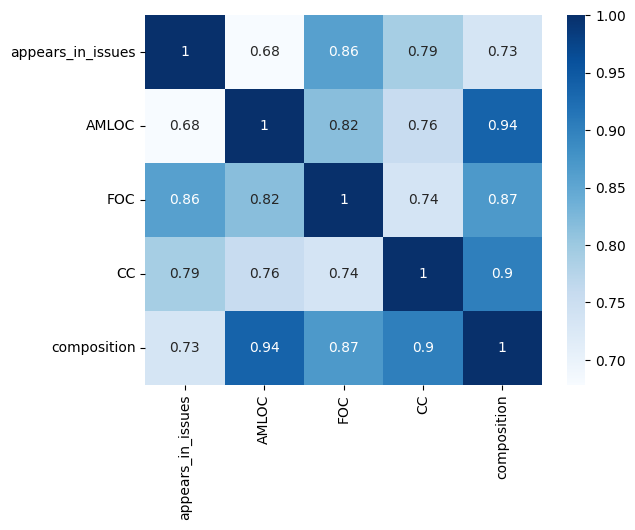

In [85]:
corr = df_critical_files_by_issues.select_dtypes('number').corr(method = 'spearman')
sns.heatmap(corr, cmap='Blues', annot = True)

## Indicência dos arquivos apenas nos Bugs

In [87]:
# @title
list_temp_key, list_issue_type, list_temp_commits, list_temp_modified_files = list(), list(), list(), list()

list_temp_commit_key_by_bugs = list()
for i in df_cassandra_bug_issues.index:
  consulta_commits = df_cassandra_bug_issues['commits'][i]
  if consulta_commits is not None:
    if len(consulta_commits) > 0:
      for each_commit in consulta_commits:
        #print(df_cassandra_all_issues['key'][i], df_cassandra_all_issues['commits'][i], df_cassandra_all_issues['modified_files'][i])
        if df_cassandra_bug_issues['key'][i] not in list_temp_key:
          list_temp_key.append(df_cassandra_bug_issues['key'][i])
          list_issue_type.append(df_cassandra_bug_issues['issue_type'][i])
          commits_separated_by_commas = ",".join(df_cassandra_bug_issues['commits'][i])
          list_temp_commits.append(commits_separated_by_commas)
          list_temp_modified_files.append(df_cassandra_bug_issues['modified_files'][i])
          l_temp_commits = commits_separated_by_commas.split(',')
          for e in l_temp_commits:
            elemento = (e, df_cassandra_bug_issues['key'][i])
            list_temp_commit_key_by_bugs.append(elemento)

dict_temp_2 = {
    'keys':list_temp_key, 'issue_type':list_issue_type, 'commits':list_temp_commits, 'modified_files':list_temp_modified_files
}

df_temp_2 = pd.DataFrame(dict_temp_2)
df_temp_2

,keys,issue_type,commits,modified_files
0,CASSANDRA-263,Bug,9164940f41972e3611d1ad38a903ca39562e6feb,"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,ef203cf00070fd719f87db9dd2384b8bc116ebd6,"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,cdd8b170628176924c21db1cb6dcbecf4c7f2148,"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-163,Bug,"74dcfb263ca695534ec631d8cf11f909e54a9765,af47d...","[[Memtable.java], [Memtable.java], [DatabaseDe..."
4,CASSANDRA-155,Bug,"7518f7ce9f012cf5a5bbcf976a1590a1b5531db0,34630...","[[ColumnFamilyStore.java, Memtable.java, Compa..."
...,...,...,...,...
885,CASSANDRA-10000,Bug,5768e5ae41879885e7e2aca79b38bed53df55711,[[EmptyValuesTest.java]]
886,CASSANDRA-9914,Bug,bb36090fa0858456fb1ba80adf71fb3dc24a1aac,"[[build.xml, KeepBriefBrief.java]]"
887,CASSANDRA-9880,Bug,6c90950489a42a38a6ddfa45f79c84a110dffbe7,"[[Verb.java, Message.java, ReflectionUtils.jav..."
888,CASSANDRA-9814,Bug,"c1bf002234bd44bce120658e9b08b3d67901e5bb,738df...","[[build.xml], [build.xml]]"


In [ ]:
# 4. Extract Commit and Issue Data
#commits = list(RepositoryMining(github_repo_url).traverse_commits())

# Assuming you have a Jira API or library to fetch issue data
# issues = fetch_jira_issues(jira_url)

In [88]:
# 5. Data preparation
# Filter commits made for this repository
# repository_commits = [commit for commit in commits if commit.project_name == 'your_repository']
repository_commits = dict_commit_modified_files.keys()

In [89]:
# Extract modified files from each commit
#modified_files = [(commit.hash, file) for commit in repository_commits for file in commit.modifications]
modified_files = []
for k, v in dict_commit_modified_files.items():
  for each in v[1]:
    elemento = (k, each)
    modified_files.append(elemento)

In [90]:
len(list_temp_commit_key_by_bugs)

1780

In [91]:
# Assuming you have a function to extract the issues mentioned in commits
#commit_issues = extract_issues_mentioned_in_commits(repository_commits, issues)
commit_bug_issues = list_temp_commit_key_by_bugs

In [94]:
# Create a Pandas DataFrame for further analysis
commit_df = pd.DataFrame(modified_files, columns=['CommitHash', 'ModifiedFile'])
bug_issue_df = pd.DataFrame(commit_bug_issues, columns=['CommitHash', 'IssueID'])

In [95]:
commit_df

,CommitHash,ModifiedFile
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,JSAP-2.1.jar
1,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,activation.jar
2,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.6.jar
3,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.7.jar
4,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-3.0.1.jar
...,...,...
98820,2b23fc58aa86a1cd0c98f97ddcf43305869d041e,jvm17-server.options
98821,2b23fc58aa86a1cd0c98f97ddcf43305869d041e,GCInspector.java
98822,15f355a0062148e1ca511e8fc515e0cba380790d,CHANGES.txt
98823,15f355a0062148e1ca511e8fc515e0cba380790d,SSTableLoader.java


In [96]:
bug_issue_df

,CommitHash,IssueID
0,9164940f41972e3611d1ad38a903ca39562e6feb,CASSANDRA-263
1,ef203cf00070fd719f87db9dd2384b8bc116ebd6,CASSANDRA-262
2,cdd8b170628176924c21db1cb6dcbecf4c7f2148,CASSANDRA-261
3,74dcfb263ca695534ec631d8cf11f909e54a9765,CASSANDRA-163
4,af47dc8476a6e4e4856476e4acff1ac8321a6a39,CASSANDRA-163
...,...,...
1775,bb36090fa0858456fb1ba80adf71fb3dc24a1aac,CASSANDRA-9914
1776,6c90950489a42a38a6ddfa45f79c84a110dffbe7,CASSANDRA-9880
1777,c1bf002234bd44bce120658e9b08b3d67901e5bb,CASSANDRA-9814
1778,738dfde73560d289218f3afa4103a37e9f401757,CASSANDRA-9814


In [97]:
# 6. Correlation Analysis
# Group by files and count how many times each file appears in issues
file_bug_issue_counts = bug_issue_df['IssueID'].groupby(bug_issue_df['CommitHash']).count().reset_index()

In [98]:
# Merge with commit data
merged_data_bug_issues = pd.merge(commit_df, file_bug_issue_counts, on='CommitHash', how='left')

In [100]:
# Create a table showing files and the number of times they appeared in issues
file_bug_issue_summary = merged_data_bug_issues.groupby('ModifiedFile')['IssueID'].sum().reset_index()
file_bug_issue_summary.rename(columns={'IssueID': 'TimesAppearedInBugIssues'}, inplace=True)


In [101]:
file_bug_issue_summary.sort_values(by='TimesAppearedInBugIssues', ascending=False).head(50)

,ModifiedFile,TimesAppearedInBugIssues
683,CHANGES.txt,946.0
5476,StorageService.java,160.0
1076,ColumnFamilyStore.java,139.0
1603,DatabaseDescriptor.java,90.0
6459,build.xml,82.0
1251,CompactionManager.java,72.0
5473,StorageProxy.java,71.0
6633,cassandra.yaml,67.0
3649,NEWS.txt,63.0
1355,Config.java,58.0


In [ ]:
# 7. Analyze Results
# DataFrame (file_issue_summary) that contains information about how many times each modified file appeared in issues.
# Analyze and visualize this data to draw conclusions about the correlation between file modifications and issues.

In [102]:
file_bug_issue_summary[file_bug_issue_summary['ModifiedFile'].str.contains(".java")].sort_values(by='TimesAppearedInBugIssues', ascending=False).head(50)

,ModifiedFile,TimesAppearedInBugIssues
5476,StorageService.java,160.0
1076,ColumnFamilyStore.java,139.0
1603,DatabaseDescriptor.java,90.0
1251,CompactionManager.java,72.0
5473,StorageProxy.java,71.0
1355,Config.java,58.0
676,CFMetaData.java,55.0
3492,MessagingService.java,50.0
4817,SSTableReader.java,47.0
2263,Gossiper.java,44.0


### Testa correlação classes críticas e classes de alta inciência nos Bugs

Relação de arquivos que aparecem em muitos Bugs



In [103]:
df_files_in_bug_issues = file_bug_issue_summary[file_bug_issue_summary['ModifiedFile'].str.contains(".java")].sort_values(by='TimesAppearedInBugIssues', ascending=False)
df_files_in_bug_issues

,ModifiedFile,TimesAppearedInBugIssues
5476,StorageService.java,160.0
1076,ColumnFamilyStore.java,139.0
1603,DatabaseDescriptor.java,90.0
1251,CompactionManager.java,72.0
5473,StorageProxy.java,71.0
...,...,...
2516,IMessageCallback.java,0.0
2515,IMessage.java,0.0
2514,IMergeIterator.java,0.0
2513,IMeasurableMemory.java,0.0


In [104]:
df_files_in_bug_issues.sort_values(by='TimesAppearedInBugIssues', ascending=False).head(50)

,ModifiedFile,TimesAppearedInBugIssues
5476,StorageService.java,160.0
1076,ColumnFamilyStore.java,139.0
1603,DatabaseDescriptor.java,90.0
1251,CompactionManager.java,72.0
5473,StorageProxy.java,71.0
1355,Config.java,58.0
676,CFMetaData.java,55.0
3492,MessagingService.java,50.0
4817,SSTableReader.java,47.0
2263,Gossiper.java,44.0


Filtra apenas os arquivos com Bug issues que aparecem no ATDCodeAnalyzer

In [105]:
list_file, list_appears_in_bug_issues = list(), list()

for i in df_files_in_bug_issues.index:
  if df_files_in_bug_issues['ModifiedFile'][i] in lista_nomes_arquivos_criticos:
    file = df_files_in_bug_issues['ModifiedFile'][i]
    appears_in_issues = df_files_in_bug_issues['TimesAppearedInBugIssues'][i]
    list_file.append(file)
    list_appears_in_bug_issues.append(appears_in_issues)

dict_critical_files_by_bug_issues = {
    'file':list_file, 'appears_in_bug_issues':list_appears_in_bug_issues
}

df_critical_files_by_bug_issues = pd.DataFrame(dict_critical_files_by_bug_issues)
df_critical_files_by_bug_issues

,file,appears_in_bug_issues
0,StorageService.java,160.0
1,ColumnFamilyStore.java,139.0
2,DatabaseDescriptor.java,90.0
3,CompactionManager.java,72.0
4,StorageProxy.java,71.0
5,Config.java,58.0
6,MessagingService.java,50.0
7,SSTableReader.java,47.0
8,NodeProbe.java,39.0
9,SelectStatement.java,39.0


Faz a composição dos dados dos arquivos em muitos Bugs e dos arquivos identificados via ATDCodeAnalyzer

In [106]:
df_critical_files_by_atd.sort_values(by='composition', ascending=False)

,file,AMLOC,FOC,CC,composition
9,StorageService.java,3537,144,838,426816864
1,DatabaseDescriptor.java,2092,87,471,85723884
2,ColumnFamilyStore.java,1966,89,373,65265302
7,StorageProxy.java,1667,53,377,33308327
8,CompactionManager.java,1279,74,265,25081190
11,SSTableReader.java,767,53,324,13170924
4,SelectStatement.java,1174,44,177,9143112
3,CassandraDaemon.java,1001,51,117,5972967
5,SinglePartitionReadCommand.java,994,38,157,5930204
10,NodeProbe.java,513,37,255,4840155


In [107]:
df_critical_files_by_bugs = pd.merge(df_critical_files_by_bug_issues, df_critical_files_by_atd, on='file', how='inner')
df_critical_files_by_bugs

,file,appears_in_bug_issues,AMLOC,FOC,CC,composition
0,StorageService.java,160.0,3537,144,838,426816864
1,ColumnFamilyStore.java,139.0,1966,89,373,65265302
2,DatabaseDescriptor.java,90.0,2092,87,471,85723884
3,CompactionManager.java,72.0,1279,74,265,25081190
4,StorageProxy.java,71.0,1667,53,377,33308327
5,Config.java,58.0,553,52,12,345072
6,MessagingService.java,50.0,574,36,165,3409560
7,SSTableReader.java,47.0,767,53,324,13170924
8,NodeProbe.java,39.0,513,37,255,4840155
9,SelectStatement.java,39.0,1174,44,177,9143112


Faz correlação entre os atributos: AMLOC, FOC, CC e appears_in_bug_issues

In [108]:
df_critical_files_by_bugs.corr(method='spearman')


<ipython-input-108-185c9aac9215>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_critical_files_by_bugs.corr(method='spearman')


,appears_in_bug_issues,AMLOC,FOC,CC,composition
appears_in_bug_issues,1.000000,0.686516,0.831579,0.739055,0.704029
AMLOC,0.686516,1.000000,0.816113,0.755245,0.937063
FOC,0.831579,0.816113,1.000000,0.735553,0.868653
CC,0.739055,0.755245,0.735553,1.000000,0.902098
composition,0.704029,0.937063,0.868653,0.902098,1.000000


<Axes: >

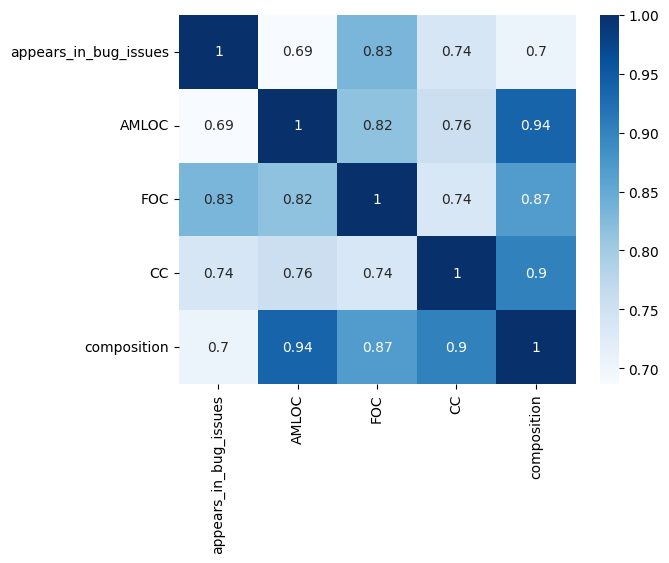

In [109]:
corr = df_critical_files_by_bugs.select_dtypes('number').corr(method = 'spearman')
sns.heatmap(corr, cmap='Blues', annot = True)

In [129]:
def resumo():
  nome_repositorio = 'Apache Cassandra'
  print(f'Repositório analisado: {nome_repositorio}')
  print('')
  link_repositorio = 'https://github.com/apache/cassandra.git'
  print(f'Link: {link_repositorio}')
  print('')
  print(f'Total de commits analisados: {total_commit_count}')
  #29156
  print('')
  print(f'Total de issues recuperados do Jira: {len(lista_key_cassandra_all_issues)}')
  #18576
  print('')
  print(f'Total de bugs analisados: {len(lista_key_cassandra_bug_issues)}')
  #10119
  print('')
  print(f'Total de issues que aparecem nas mensagens dos commits analisados: {len(list_cassandra_issues_analyzed)}')
  #4734
  print('')
  print(f'Tags analisadas pelo ATDCodeAnalizer: 3.0.0 (2015) até 3.11.11 (2021)')
  print('')
  print(f'Total de commits analisados pelo ATDCodeAnalyzer: 5559')
  print('')
  print(f'Arquivos críticos identificados pelo ATDCodeAnalyzer: {len(lista_nomes_arquivos_criticos)}')
  for each in lista_nomes_arquivos_criticos:
    print(each)

# Resumo

Análise de correlação entre as classes críticas encontradas via ATDCodeAnalyzer incidência nos issues e incidência nos bugs.

## Sumário

In [130]:
resumo()

Repositório analisado: Apache Cassandra

Link: https://github.com/apache/cassandra.git

Total de commits analisados: 29156

Total de issues recuperados do Jira: 18576

Total de bugs analisados: 10119

Total de issues que aparecem nas mensagens dos commits analisados: 4734

Tags analisadas pelo ATDCodeAnalizer: 3.0.0 (2015) até 3.11.11 (2021)

Total de commits analisados pelo ATDCodeAnalyzer: 5559

Arquivos críticos identificados pelo ATDCodeAnalyzer: 12
StorageService.java
ColumnFamilyStore.java
DatabaseDescriptor.java
CompactionManager.java
StorageProxy.java
SSTableReader.java
Config.java
CassandraDaemon.java
SelectStatement.java
SinglePartitionReadCommand.java
NodeProbe.java
MessagingService.java


## Incidência dos arquivos críticos nos issues do Cassandra

In [112]:
df_critical_files_by_issues

,file,appears_in_issues,AMLOC,FOC,CC,composition
0,StorageService.java,967.0,3537,144,838,426816864
1,ColumnFamilyStore.java,832.0,1966,89,373,65265302
2,DatabaseDescriptor.java,659.0,2092,87,471,85723884
3,StorageProxy.java,463.0,1667,53,377,33308327
4,CompactionManager.java,406.0,1279,74,265,25081190
5,Config.java,379.0,553,52,12,345072
6,SSTableReader.java,352.0,767,53,324,13170924
7,MessagingService.java,288.0,574,36,165,3409560
8,NodeProbe.java,287.0,513,37,255,4840155
9,SelectStatement.java,245.0,1174,44,177,9143112


## Incidência dos arquivos críticos nos Bugs do Cassandra

In [113]:
df_critical_files_by_bugs_summary = df_critical_files_by_bugs[['file', 'appears_in_bug_issues']]
df_critical_files_by_bugs_summary

,file,appears_in_bug_issues
0,StorageService.java,160.0
1,ColumnFamilyStore.java,139.0
2,DatabaseDescriptor.java,90.0
3,CompactionManager.java,72.0
4,StorageProxy.java,71.0
5,Config.java,58.0
6,MessagingService.java,50.0
7,SSTableReader.java,47.0
8,NodeProbe.java,39.0
9,SelectStatement.java,39.0


## Merge dos dados dos arquivos críticos com issues e bugs

In [120]:
df_critical_files_by_atd_final = pd.merge(df_critical_files_by_issues, df_critical_files_by_bugs_summary, how='inner', on='file')
colunas = ['file', 'appears_in_issues', 'appears_in_bug_issues','AMLOC', 'FOC','CC','composition']
df_critical_files_by_atd_final = df_critical_files_by_atd_final[colunas]
df_critical_files_by_atd_final

,file,appears_in_issues,appears_in_bug_issues,AMLOC,FOC,CC,composition
0,StorageService.java,967.0,160.0,3537,144,838,426816864
1,ColumnFamilyStore.java,832.0,139.0,1966,89,373,65265302
2,DatabaseDescriptor.java,659.0,90.0,2092,87,471,85723884
3,StorageProxy.java,463.0,71.0,1667,53,377,33308327
4,CompactionManager.java,406.0,72.0,1279,74,265,25081190
5,Config.java,379.0,58.0,553,52,12,345072
6,SSTableReader.java,352.0,47.0,767,53,324,13170924
7,MessagingService.java,288.0,50.0,574,36,165,3409560
8,NodeProbe.java,287.0,39.0,513,37,255,4840155
9,SelectStatement.java,245.0,39.0,1174,44,177,9143112


## Correlação entre as métricas (AMLOC, FOC, CC), incidência de issues e incidência de bugs

In [121]:
df_critical_files_by_atd_final.corr(method='spearman')

<ipython-input-121-5ec9ec5ac918>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_critical_files_by_atd_final.corr(method='spearman')


,appears_in_issues,appears_in_bug_issues,AMLOC,FOC,CC,composition
appears_in_issues,1.000000,0.984240,0.678322,0.858145,0.790210,0.734266
appears_in_bug_issues,0.984240,1.000000,0.686516,0.831579,0.739055,0.704029
AMLOC,0.678322,0.686516,1.000000,0.816113,0.755245,0.937063
FOC,0.858145,0.831579,0.816113,1.000000,0.735553,0.868653
CC,0.790210,0.739055,0.755245,0.735553,1.000000,0.902098
composition,0.734266,0.704029,0.937063,0.868653,0.902098,1.000000


<Axes: >

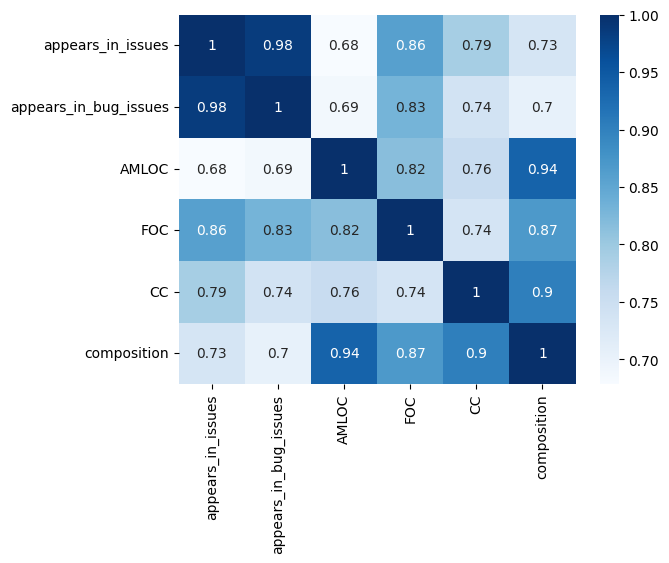

In [122]:
corr = df_critical_files_by_atd_final.select_dtypes('number').corr(method = 'spearman')
sns.heatmap(corr, cmap='Blues', annot = True)